# 05_image embeddings focus -- 2022-09-26-unlabeled yale fossils dataset.ipynb

Inputs: version 1 of the cleaned 2022 unlabeled yale fossils dataset, having identified & removed **irrelevant outlier images**

Outputs: version 2 of the cleaned 2022 unlabeled yale fossils dataset, having identified & removed **duplicate images** as well

Created by: Jacob A Rose  
Created on: Monday September 26th, 2022  
<!-- Updated on:  -->


### To reference:
* https://github.com/minimaxir/imgbeddings/blob/main/examples/pokemon.ipynb

In [3]:
%load_ext autoreload
%autoreload 2


from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.float_format', "{:,.2f}".format)

from rich import print as pp
import meerkat as mk
display_res = 1024

mk.config.display.max_rows = 100
mk.config.display.max_image_width = display_res
mk.config.display.max_image_height = display_res
pp(dict(vars(mk.config.display)))



import os
import numpy as np
from typing import *
import inspect
from tqdm.auto import tqdm
from pathlib import Path
import logging

from PIL import Image
import PIL
from PIL.ImageStat import Stat
import PIL.Image
import cv2
import glob
from joblib import Parallel, delayed

import math
from pathlib import Path
import matplotlib.pyplot as plt

{'max_rows': 100, 'show_images': True, 'max_image_height': 1024, 'max_image_width': 1024, 'show_audio': True}

In [4]:
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)

## Functions

In [5]:

def rescale_image(img: np.ndarray, max_size: int=512) -> np.ndarray:
    h, w, c = img.shape
    scale = min([max_size/h, max_size/w])
    output_size = int(scale*w), int(scale*h)
    
    return cv2.resize(img, output_size, interpolation=cv2.INTER_AREA)

def rescale_image_PIL(img: PIL.Image.Image, max_size: int=512) -> PIL.Image:
    # print(img)
    # img.load()
    w, h = img.width, img.height
    scale = max([max_size/w, max_size/h])
    output_size = int(scale*w), int(scale*h)
    
    return img.resize(output_size, resample=PIL.Image.Resampling.BICUBIC)



def hconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
    h_min = min(im.shape[0] for im in im_list)
    im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=interpolation)
                      for im in im_list]
    return cv2.hconcat(im_list_resize)


def image_grid(image_paths, 
               col: int=5,
               max_imgs: int=-1,
               include_filenames_as_titles=False):
    
    if max_imgs > 0:
        image_paths = image_paths[:max_imgs]
    
    image_count = len(image_paths)
    row = math.ceil(image_count/col)
    fig = plt.figure(figsize=(col*4,row*4))

    for i, img_path in enumerate(image_paths):
        img_path = str(img_path)

        img = plt.imread(img_path)

        ax = plt.subplot(row, col, i + 1)
        plt.imshow(img)
        if include_filenames_as_titles:
            plt.title(Path(img_path).name)

        # ax.set_xticklabels([])
        # ax.set_yticklabels([])

        plt.axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, top=0.97)
    return fig



In [6]:
def is_empty(path):
    """
    Returns True if the input path is an empty directory, False if anything's in it. Throws an error if target isn't a directory.
    
    """
    
    return len(os.listdir(path)) == 0

def get_version_from_path(path: str) -> int:
    path = Path(path).stem
    return int(path.split("_")[1])



def get_latest_version(root_dir: str,
                       skip_version_if_exists: bool=False) -> Path:
    """
    
    Input a root dir, and this function will either create & return a new subdir labeled "version_0", or it will find the latest created version that doesn't have any files in it.
    
    Should run once in an experiment & save in a variable if need to reference version elsewhere in script.
    
    root_dir: str
        Location in which multiple version subdirs will be located (e.g. "./version_{0,1,2,3...}"
    skip_version_if_exists: bool, default=False
        If False, attempt to load previous annotations if found on disk. If True, always go to the next version number if version subdir is not empty.
        By default, attempts to load previous annotations if they exist.
    
    """
    v = 0
    if not is_empty(root_dir):
        for d in sorted(os.listdir(root_dir)):
            v = max([v, get_version_from_path(d)])
            if (
                skip_version_if_exists
                and (not is_empty(Path(root_dir, d)))
            ):
                v = get_version_from_path(d) + 1

    save_dir = Path(root_dir, f"version_{v}")
    os.makedirs(save_dir, exist_ok=True)
    
    return save_dir

### Functions for caching annotations

* Functions to load (`load_cached_annotations` and save (`cache_annotations`) versioned catalogs of annotated/labeled datasets to iteratively work through a large set in many small increments.

* Saves an `annotated_df` and a `non_annotated_df` containing the same columns, with the latter having NaN for all values of the `label` column.

In [7]:
from typing import *


def cache_annotations(save_dir: str,
                      annotated_df: pd.DataFrame,
                      non_annotated_df: pd.DataFrame
                     ) -> None:
    """
    Save 2 different dataframes into a cache directory as parquet & csv files.
    
    The 1st contains only rows that have been manually annotated at least once.
    The 2nd contains only rows that have never been annotated (indicated by a value of label=="")
    """
    annotations_cache_dir = Path(save_dir, "annotations_cache")
    os.makedirs(annotations_cache_dir, exist_ok=True)

    annotated_df.to_parquet(annotations_cache_dir / f"annotated.parquet")
    annotated_df.to_csv(annotations_cache_dir / f"annotated.csv")
    annotated_df.describe(include='all').to_csv(annotations_cache_dir / "annotated_summary.csv")

    non_annotated_df.to_parquet(annotations_cache_dir / f"non_annotated.parquet")
    non_annotated_df.to_csv(annotations_cache_dir / f"non_annotated.csv")
    non_annotated_df.describe(include='all').to_csv(annotations_cache_dir / "non_annotated_summary.csv")
    
    
def load_cached_annotations(
    save_dir: str
) -> Tuple[Any]:
    """
    Load 2 different dataframes from a cache directory from either parquet or csv files.
    
    The 1st contains only rows that have been manually annotated at least once.
    The 2nd contains only rows that have never been annotated (indicated by a value of label=="")
    """
    annotations_cache_dir = Path(save_dir, "annotations_cache")
    if not os.path.isdir(annotations_cache_dir):
        return None, None
    
    
    if os.path.isfile(annotations_cache_dir / f"annotated.parquet"):
        annotated_df = pd.read_parquet(annotations_cache_dir / f"annotated.parquet")
    else:
        annotated_df = pd.read_csv(annotations_cache_dir / f"annotated.csv", index_col=0)

    if os.path.isfile(annotations_cache_dir / f"non_annotated.parquet"):
        non_annotated_df = pd.read_parquet(annotations_cache_dir / f"non_annotated.parquet")
    else:
        non_annotated_df = pd.read_csv(annotations_cache_dir / f"non_annotated.csv", index_col=0)


    return annotated_df, non_annotated_df

## Specify & Load dataset

### Define key file info & metadata

In [8]:
yale_fossil_dir = "/media/data_cifs/projects/prj_fossils/data/yale_full"

analysis_results_root_dir = "/media/data_cifs/projects/prj_fossils/users/jacob/github/image-utils/notebooks/fossil dataset preprocessing/2022-yale_fossil/analysis_results/"
results_filename = "05_image_stats_df"

meerkat_dir = os.path.join(analysis_results_root_dir, "meerkat")
meerkat_path = os.path.join(meerkat_dir, "02b_rich_metadata_embedded_images_meerkat_datapanel")

In [9]:
annotations_dir = "/media/data_cifs/projects/prj_fossils/users/jacob/github/image-utils/notebooks/fossil dataset preprocessing/2022-yale_fossil/manual_annotations"
save_dir = get_latest_version(root_dir=annotations_dir)
print(f"Checking for cached annotations in {save_dir}")
pp(f'Loading from: {Path(save_dir).stem.replace("_", " ")}')
# cache_annotations(save_dir=save_dir,
#                   annotated_df=annotated_df,
#                   non_annotated_df=non_annotated_df)


annotated_df, non_annotated_df = load_cached_annotations(save_dir=save_dir)
if (
    isinstance(annotated_df, pd.DataFrame) 
    and isinstance(non_annotated_df, pd.DataFrame)
):
    df = pd.concat([
        non_annotated_df, annotated_df
    ])
    dp = mk.DataPanel.from_pandas(df)
    print(f"Successfully loaded from cache")
else:
    dp = mk.DataPanel.read(meerkat_path)
    print(f"No cache exists, loading raw data")

Checking for cached annotations in /media/data_cifs/projects/prj_fossils/users/jacob/github/image-utils/notebooks/fossil dataset preprocessing/2022-yale_fossil/manual_annotations/version_0


Loading from: version 0

Successfully loaded from cache


In [10]:
annotated_df.describe(include='all')
non_annotated_df.describe(include='all')

,label,thumb_path,path,r,g,b,h,s,v,height,width,aspect_ratio,kingdom,phylum,class,order,family,genus,specificEpithet,taxonRank,vernacularName,continent,country,stateProvince,county,municipality,locality,higherGeography,formation,scientificName,higherClassification,earliestPeriodOrLowestSystem,earliestEpochOrLowestSeries,earliestAgeOrLowestStage,bibliographicCitation,references,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,occurrenceID,catalogNumber,occurrenceRemarks,recordedBy,identifier,id,modified,previousIdentifications,georeferencedBy,georeferencedDate,georeferenceSources,dynamicProperties,error
count,235,235,235,235.00,235.00,235.00,235.00,235.00,235.00,235.00,235.00,235.00,233,229,187,210,217,230,230,233,233,107,107,100,100,97,70,107,46,235,233,98,6,4,235,235,105.00,105.00,105.00,235,235,235,89,235,235,235,233,103,105,105,235,0
unique,3,235,235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,3,20,28,39,67,2,17,3,6,13,16,18,18,25,7,74,35,13,5,3,231,231,NaN,NaN,NaN,231,231,231,9,235,231,10,73,3,17,1,231,0
top,unknown,/dev/shm/jrose3/2022-yale_fossils/image_thumbnails/res=512/urn:uuid:718fc57c-38da-42c8-b9ea-cf60c5a8f01f.jpg,/media/data_cifs/projects/prj_fossils/data/yale_full/urn:uuid:9fff701e-bad0-418a-b5d4-0d6019390422.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Plantae,Tracheophyta,Gymnospermopsida,Cycadeoidales,Cycadeoidaceae,Cycadeoidea,sp.,Species,tracheophytes; plants,North America,USA,South Dakota,Fall River County,Minnekahta,"4 miles southwest of Minnekahta, middle of patch",North America; USA; South Dakota; Fall River County; Minnekahta,Lakota Fm,Cycadeoidea sp.,Plantae; Tracheophyta; Gymnospermopsida; Cycadeoidales; Cycadeoidaceae,Early Cretaceous,Late Eocene,Maastrichtian,Psaronius conjugatus (YPM PB 035827),http://collections.peabody.yale.edu/search/Record/YPM-PB-035827,NaN,NaN,NaN,urn:uuid:14829c3f-26bb-4ba1-be6b-6808c34b6527,YPM PB 035827,Sectioned trunk of a tree fern. Central vascular portion and enclosing root mass.; PB number 35827; lot count 1,H. F. Wells,urn:uuid:3979a412-7b26-4638-b588-5de6ae741c04,urn:uuid:14829c3f-26bb-4ba1-be6b-6808c34b6527,2022-03-09T21:55:46.000Z,Cycadeoidea sp.,Dylan Young,5/5/2015,GEOLocate,"{ ""irn"": ""768886"", ""media"": ""409256:541e2bc8-fdc9-4254-b8e2-d11f1f9fec84 409257:44316add-5edc-4bd4-ab31-af0f0dd7af0b 531532:a59be105-025f-4ede-80d0-da9e673a1a63 531533:c8fd68e3-39f0-44d0-8c0a-8faf35882199"", ""mm_repository_id"": ""409256"", ""solr_long_lat"": ""12.91995,50.8292"" }",NaN
freq,110,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233,228,181,177,177,172,35,230,188,98,92,69,62,59,19,59,32,32,177,68,2,2,3,3,NaN,NaN,NaN,3,3,3,60,1,3,183,32,89,68,105,3,NaN
mean,NaN,NaN,NaN,235.12,230.12,213.23,38.09,30.71,237.95,"4,755.94","5,907.33",0.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.90,-92.90,"19,277.08",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,8.22,9.34,17.82,25.82,16.88,5.77,"1,686.53","2,348.84",0.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.48,29.68,"55,734.41",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,211.40,191.78,122.33,4.31,4.53,228.74,419.00,477.00,0.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.00,-113.17,80.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,230.34,224.00,202.06,24.81,17.79,232.99,"4,000.00","4,000.00",0.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.39,-103.75,"3,036.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,235.45,231.03,214.64,31.30,29.15,237.69,"4,000.00","6,000.00",0.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.43,-103.69,"5,828.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,240.80,237.24,225.71,43.30,39.47,242.49,"6,000.00","6,000.00",0.79,NaN,N

,label,thumb_path,path,r,g,b,h,s,v,height,width,aspect_ratio,kingdom,phylum,class,order,family,genus,specificEpithet,taxonRank,vernacularName,continent,country,stateProvince,county,municipality,locality,higherGeography,formation,scientificName,higherClassification,earliestPeriodOrLowestSystem,earliestEpochOrLowestSeries,earliestAgeOrLowestStage,bibliographicCitation,references,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,occurrenceID,catalogNumber,occurrenceRemarks,recordedBy,identifier,id,modified,previousIdentifications,georeferencedBy,georeferencedDate,georeferenceSources,dynamicProperties,error
count,16209,16209,16209,"16,209.00","16,209.00","16,209.00","16,209.00","16,209.00","16,209.00","16,209.00","16,209.00","16,209.00",16170,15282,4822,13717,8882,15209,14081,16170,16170,13829,13874,13231,12136,12005,5847,13874,10794,16208,16170,13330,7255,8310,16209,16209,"13,737.00","13,737.00","13,653.00",16209,16209,16209,12221,16209,16209,16209,16170,12899,13650,13670,16209,4
unique,1,16209,16209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,14,26,86,188,647,1294,11,82,5,31,62,191,358,371,483,115,2036,274,55,43,65,14937,14937,NaN,NaN,NaN,14937,14937,12839,195,16209,14937,2146,2097,8,102,5,14937,2
top,,/dev/shm/jrose3/2022-yale_fossils/image_thumbnails/res=512/urn:uuid:cb10d207-a85a-4dae-9976-a7f126aa2e2b.jpg,/media/data_cifs/projects/prj_fossils/data/yale_full/urn:uuid:7fdf2a76-7aea-4b16-ac5f-8daf54335659.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Plantae,Tracheophyta,Lycopsida,Marattiales,Calamitaceae,Pecopteris,sp.,Species,tracheophytes; plants,North America,USA,Illinois,Grundy County,Mazon Creek,Woodbridge Clay; Amboy Clays,North America; USA; Illinois; Grundy County; Mazon Creek,Carbondale Fm,Pecopteris sp.,Plantae; Tracheophyta; Marattiales,Middle Pennsylvanian,Carboniferous,Desmoinesian,Calamites sp. (YPM PB 045160),http://collections.peabody.yale.edu/search/Record/YPM-PB-000678,NaN,NaN,NaN,urn:uuid:8d7421ea-3b6e-47b7-bc29-6e8188b00706,YPM PB 003129,leaf; PB number 73504; lot count 1; accn=YPM.10426,Samuel S. Strong,urn:uuid:fcf3311b-016b-4155-8fd9-eb2670c6864d,urn:uuid:8d7421ea-3b6e-47b7-bc29-6e8188b00706,2020-10-03T14:18:59.000Z,Pecopteris sp.,Dylan Young,2/4/2015,GEOLocate,"{ ""irn"": ""741673"", ""media"": ""409246:69e73d8a-6fba-4950-bdce-a927193903c0 531500:09a5f249-713c-4b97-88a8-5e0cf720a524 531501:83e0f8eb-56ea-4ba1-9063-992526e9aa97 531502:c385ab8b-0070-4316-82fc-cf4a3a601af5 961021:492c2dd7-0a31-4373-be46-18b3cb904599"", ""mm_repository_id"": ""409246"", ""solr_long_lat"": ""-88.418495,41.285087"" }",image file is truncated (0 bytes not processed)
freq,16209,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16136,15167,1745,4206,1720,4166,6412,13890,10637,13158,12756,4894,4856,4841,423,4841,4855,3540,4190,5035,4603,4848,5,5,NaN,NaN,NaN,5,5,6,4773,1,5,5202,3522,11788,4885,13574,5,3
mean,NaN,NaN,NaN,138.53,111.65,78.50,31.52,118.93,138.90,"2,645.96","2,832.20",1.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.72,-87.57,"22,943.35",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,34.63,32.56,33.72,18.13,44.61,34.74,"1,046.97","1,114.58",0.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.08,24.34,"138,034.16",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,18.64,18.24,9.78,4.42,4.36,19.68,198.00,284.00,0.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-49.05,-151.53,80.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,115.77,90.14,56.04,21.88,89.76,116.02,"1,988.00","2,039.00",0.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.48,-98.20,"2,929.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,140.85,111.10,71.69,25.34,126.15,141.19,"2,586.00","2,990.00",0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [11]:
cols = dp.columns
dp = dp.sort(by="v", ascending=False)

In [12]:
image_record_cols = [
    'thumbnail',
    'thumb_path',
    'path'
]


stats_cols = [    
    # 'thumbnail',
    'thumb_path',
    'path',
    'r',
    'g',
    'b',
    'h',
    's',
    'v',
    'height',
    'width',
    'aspect_ratio'
]

geo_cols = [
    # 'thumbnail',
    'thumb_path',
    'path',
    'kingdom',
    'phylum',
    'class',
    'order',
    'family',
    'genus',
    'specificEpithet',
    'taxonRank',
    'vernacularName',
    'continent',
    'country',
    'stateProvince',
    'county',
    'municipality',
    'locality'
]

column_groups = [
    "image_record_cols",
    "stats_cols",
    "geo_cols"
]



options=[
    'Fossil Leaf', 
    'Cleared Leaf',
    'other', 
    'unknown',
    ''
    ]

## Main Interface: Annotation Widget

In [14]:
# df = non_annotated_df.sort_values("v", ascending=False)
# pp(f"Skipping a total of {len(annotated_df)} previously annotated samples distributed as follows:")
# annotated_df.value_counts("label")
# pp(f"Beginning the continued annotation process on the remaining {len(non_annotated_df)} samples")

In [15]:
df = df.sort_values("v", ascending=False)

In [17]:
# root_path = "/media/data_cifs/projects/prj_fossils/data/yale_full"
root_path = "/dev/shm/jrose3/2022-yale_fossils/image_thumbnails/res=512"

paths = [Path(root_path, p) for p in os.listdir(root_path) if p not in [".ipynb_checkpoints"]]
print(len(paths))

16444


In [1]:
import torch

In [18]:
from PIL import Image

img = Image.open(paths[0])

/media/data/conda/jrose3/envs/imutils/lib/python3.8/site-packages/huggingface_hub/file_download.py:621: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


Downloading:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/862k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

array([ 0.4285677 ,  0.8456545 , -0.11844487, -0.5215584 ,  0.05690603],
      dtype=float32)

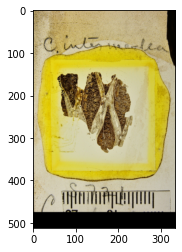

In [19]:
from imgbeddings import imgbeddings
ibed = imgbeddings()


embedding = ibed.to_embeddings(img)
embedding[0][0:5] # array([ 0.914541, 0.45988417, 0.0350069 , -0.9054574 , 0.08941309], dtype=float32)

plt.imshow(img)

In [23]:
embedding.shape

(1, 768)

<BarContainer object of 768 artists>

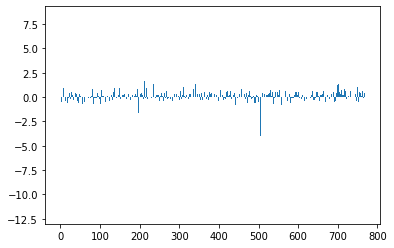

In [24]:
plt.bar(range(768), embedding.squeeze())

In [ ]:
def display_fn(filename: str, **kwargs):
    f = open(filename, "rb").read()
    return Image(value=f, format=Path(filename).suffix.strip("."), **kwargs)